<a href="https://colab.research.google.com/github/nfpaiva/ml-ai-experiments/blob/main/notebooks/additive-network-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle onnx

In [17]:
import pandas as pd
import json
import os
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report

In [7]:


# If you upload the kaggle.json file manually in the notebook environment
kaggle_token = {
    "username": "your_kaggle_username",
    "key": "your_kaggle_api_key"
}

# Save the token
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_token, f)

# Set permissions
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


### from kaggle go to settings -> create a new token -> download and manually upload kaggle.json to the ~/.kaggle/ folder using the colab file explorer

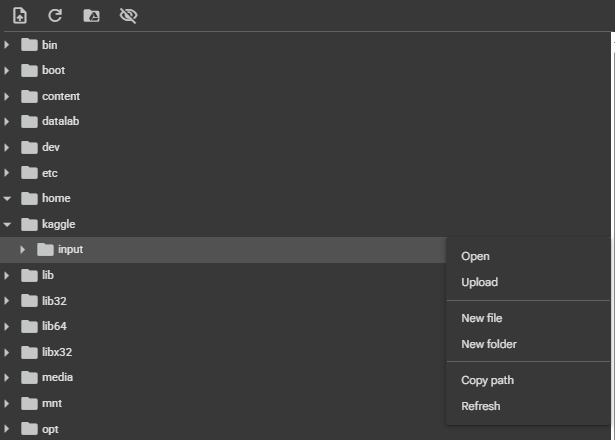

In [3]:
!kaggle datasets download -d varunchawla30/german-credit-data


Dataset URL: https://www.kaggle.com/datasets/varunchawla30/german-credit-data
License(s): DbCL-1.0


In [4]:
!unzip -o german-credit-data.zip -d german_credit_data


Archive:  german-credit-data.zip
  inflating: german_credit_data/german_credit_data.csv  


In [44]:
# Define categorical and continuous features
categorical_features = [
    'checking_account', 'credit_history', 'purpose', 'savings_account',
    'employment_duration', 'personal_status', 'guarantor', 'property',
    'other_credit', 'housing', 'job', 'telephone', 'foreign_worker'
]

continuous_features = [
    'duration_months', 'credit_amount', 'installment_rate',
    'residence_duration', 'age', 'number_existing_credits', 'dependents'
]

# Map from feature name to index
feature_to_index = {name: i for i, name in enumerate(categorical_features + continuous_features)}

In [5]:
# Load the CSV file
df = pd.read_csv("german_credit_data/german_credit_data.csv")

# Preview the data
print(df.shape)
df.head()


(1000, 21)


,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [45]:
# Dummy data setup (replace with actual data load and preprocessing)

df = df.rename(columns={"kredit": "target"})
df = df.rename(columns=column_map)


In [46]:
# Encode categorical features as indices
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Standardize continuous features
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [47]:
# Split data
X = df[categorical_features + continuous_features]
y = df["target"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

In [48]:
# Embedding-based subnetwork for categorical features
class CategoricalSubNet(nn.Module):
    def __init__(self, num_categories, embed_dim=4, hidden_dim=32, cap=5.0):
        super().__init__()
        self.embedding = nn.Embedding(num_categories, embed_dim)
        self.exu = ExULayer(embed_dim, hidden_dim, cap=cap)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x.long()).squeeze(1)
        x = self.exu(x)
        return self.linear(x)

### ✅ What is the ExU Unit?

The **ExU unit** (Exponential Unit) is defined in the paper as:

$$
h(x) = \text{ReLU}_n\left(e^{w(x - b)}\right)
$$

Where:

- \( w \) and \( b \) are **learnable parameters**.
- ReLUₙ(z) = min(max(0, z), n) — this is a **capped ReLU function**, also called **ReLU-n**.


✅ Step-by-Step ANN with Ex

🔧 1. Define the ExU-based ANN Class
We’ll use your earlier tensor-prepared dataset (X_train_tensor, etc.) and plug in the ExU layer instead of ReLU.

In [50]:
class ExULayer(nn.Module):
    def __init__(self, input_dim, output_dim, cap=5.0):
        super().__init__()
        self.w = nn.Parameter(torch.normal(mean=3.0, std=0.5, size=(output_dim, input_dim)))
        self.b = nn.Parameter(torch.randn(output_dim))
        self.cap = cap

    def forward(self, x):
        out = torch.exp(torch.matmul(x, self.w.T) - self.b)
        return torch.clamp(out, 0.0, self.cap)


In [51]:
# Subnetwork for continuous features remains the same
class ContinuousSubNet(nn.Module):
    def __init__(self, hidden_dim=32, cap=5.0):
        super().__init__()
        self.exu = ExULayer(1, hidden_dim, cap=cap)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.exu(x)
        return self.linear(x)


🧠 2. Define the Full Model using ExU

In [52]:
# Full NAM Model with embeddings
class MixedNAM(nn.Module):
    def __init__(self, categorical_dims, hidden_dim=32, cap=5.0):
        super().__init__()
        self.categorical_nets = nn.ModuleList([
            CategoricalSubNet(cat_dim, embed_dim=4, hidden_dim=hidden_dim, cap=cap)
            for cat_dim in categorical_dims
        ])
        self.continuous_nets = nn.ModuleList([
            ContinuousSubNet(hidden_dim=hidden_dim, cap=cap)
            for _ in continuous_features
        ])

    def forward(self, x):
        outputs = []
        for i, net in enumerate(self.categorical_nets):
            xi = x[:, i].unsqueeze(1)
            outputs.append(net(xi))

        offset = len(self.categorical_nets)
        for j, net in enumerate(self.continuous_nets):
            xi = x[:, offset + j].unsqueeze(1)
            outputs.append(net(xi))

        total = torch.sum(torch.cat(outputs, dim=1), dim=1, keepdim=True)
        return torch.sigmoid(total)

🏋️ 3. Training Loop

In [53]:
# Instantiate model
cat_dims = [df[col].nunique() for col in categorical_features]
model = MixedNAM(cat_dims, hidden_dim=32, cap=5.0)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop (simplified)
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 10, Loss: 1.1638
Epoch 20, Loss: 0.8235
Epoch 30, Loss: 0.6814
Epoch 40, Loss: 0.5282
Epoch 50, Loss: 0.4881



Test Accuracy: 0.7350
              precision    recall  f1-score   support

         0.0      0.569     0.597     0.583        62
         1.0      0.815     0.797     0.806       138

    accuracy                          0.735       200
   macro avg      0.692     0.697     0.694       200
weighted avg      0.739     0.735     0.737       200

ROC AUC Score: 0.7644


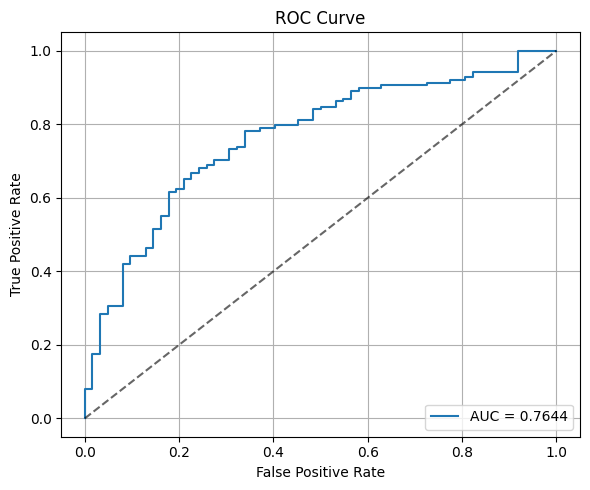

In [54]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_classes = (predictions > 0.5).float()

    # Accuracy and classification report
    accuracy = accuracy_score(y_test_tensor, predicted_classes)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(classification_report(y_test_tensor, predicted_classes, digits=3))

    # ROC AUC
    y_true = y_test_tensor.numpy()
    y_score = predictions.numpy()
    auc_score = roc_auc_score(y_true, y_score)
    print(f"ROC AUC Score: {auc_score:.4f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [56]:
def plot_feature_effect_with_hist(model, X_ref, feature_names, categorical_indices, num_points=100, bins=30):
    model.eval()
    X_ref = X_ref.clone().detach()
    num_features = X_ref.shape[1]

    fig, axes = plt.subplots(nrows=int(np.ceil(num_features / 4)), ncols=4, figsize=(24, 14))
    axes = axes.flatten()

    for i in range(num_features):
        ax = axes[i]
        ax2 = ax.twinx()

        if i in categorical_indices:
            # Categorical: use unique values from test set
            categories = torch.unique(X_ref[:, i].long())
            X_varied = X_ref[0].repeat(len(categories), 1)
            X_varied[:, i] = categories

            with torch.no_grad():
                y_pred = model(X_varied).squeeze()

            ax.plot(categories.cpu(), y_pred.cpu(), 'o-', color='blue')
            ax2.hist(X_ref[:, i].cpu().numpy(), bins=int(categories.max() + 1), alpha=0.3, color='gray', edgecolor='black')
        else:
            # Numerical: linspace variation
            x_range = torch.linspace(X_ref[:, i].min(), X_ref[:, i].max(), num_points)
            X_varied = X_ref[0].repeat(num_points, 1)
            X_varied[:, i] = x_range

            with torch.no_grad():
                y_pred = model(X_varied).squeeze()

            ax.plot(x_range.cpu(), y_pred.cpu(), color='blue')
            ax2.hist(X_ref[:, i].cpu().numpy(), bins=bins, alpha=0.3, color='gray', edgecolor='black')

        ax.set_xlabel(feature_names[i])
        ax.set_ylabel("Predicted Probability", color='blue')
        ax.tick_params(axis='y', labelcolor='blue')
        ax2.set_ylabel("Feature Frequency", color='gray')
        ax2.tick_params(axis='y', labelcolor='gray')
        ax.set_title(f"Effect of {feature_names[i]}")
        ax.grid(True)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


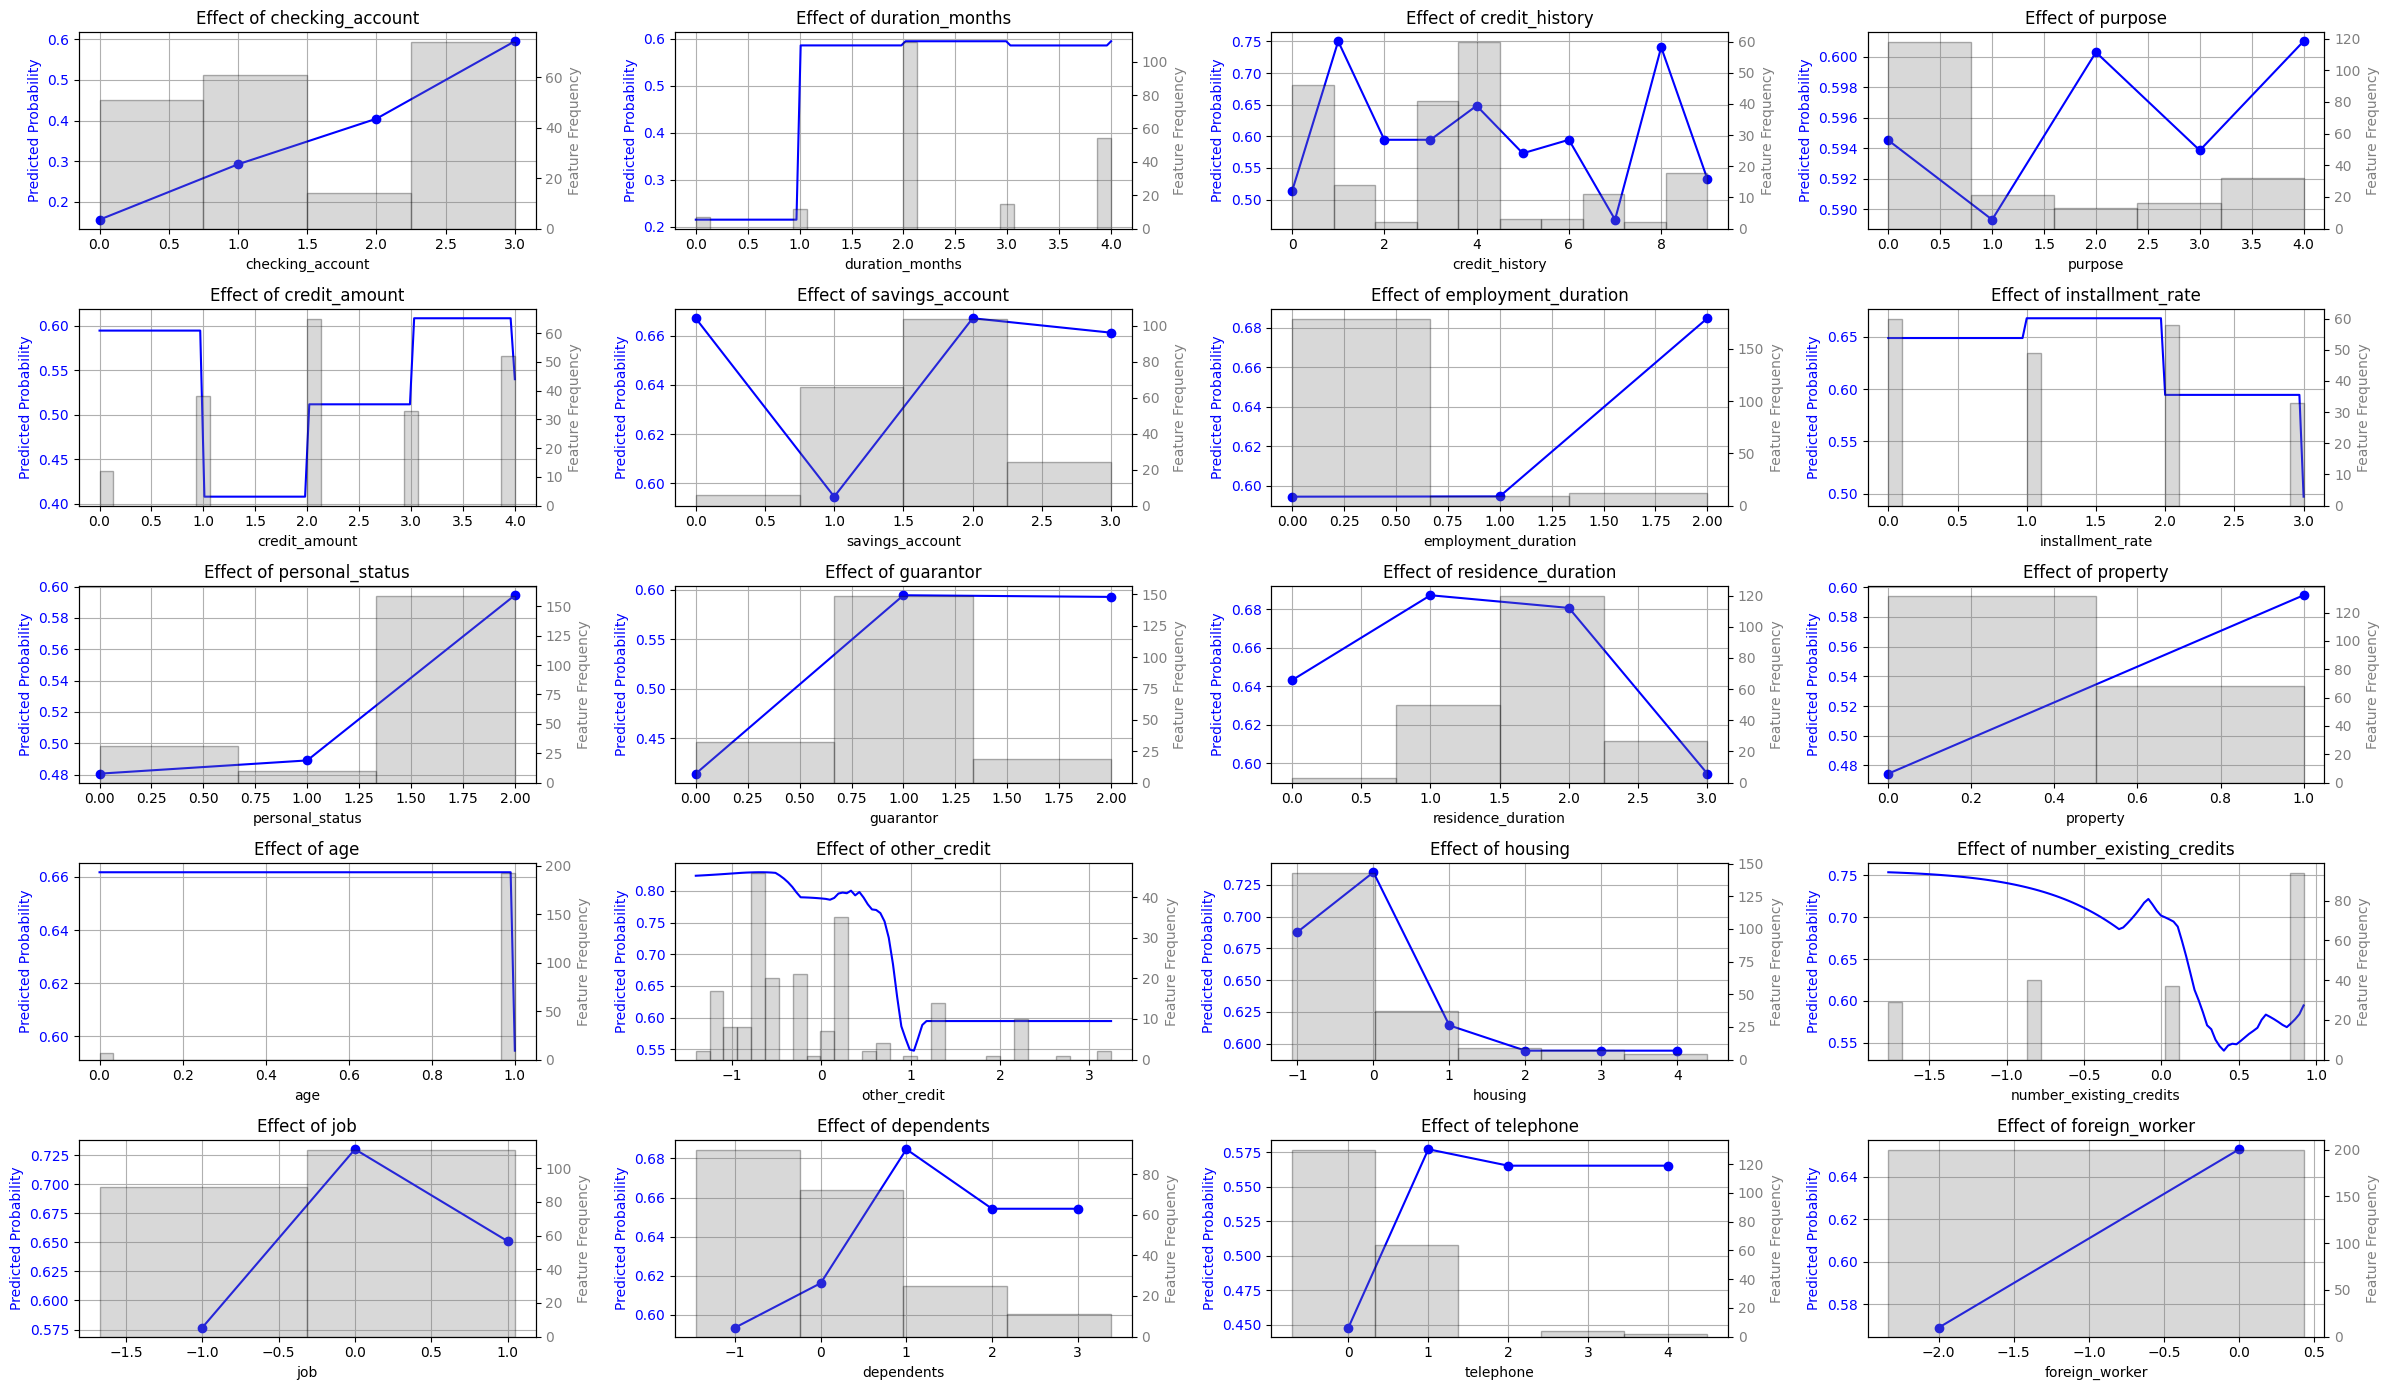

In [57]:
# Get feature names
feature_names = list(df.drop("target", axis=1).columns)

# Call the visualization function
categorical_indices = [0, 2, 3, 5, 6, 8, 9, 10, 11, 14, 16, 17, 18, 19]  # adjust for your feature set
plot_feature_effect_with_hist(model, X_test_tensor, feature_names, categorical_indices)




In [41]:
# Export your NAM model to ONNX
dummy_input = torch.randn(1, X_train_tensor.shape[1])  # use correct input dimension

torch.onnx.export(
    model,                      # your trained model
    dummy_input,                # dummy input tensor
    "nam_model.onnx",           # output ONNX file
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    opset_version=11
)



# upload onnx file to netron.app to visualize the network~

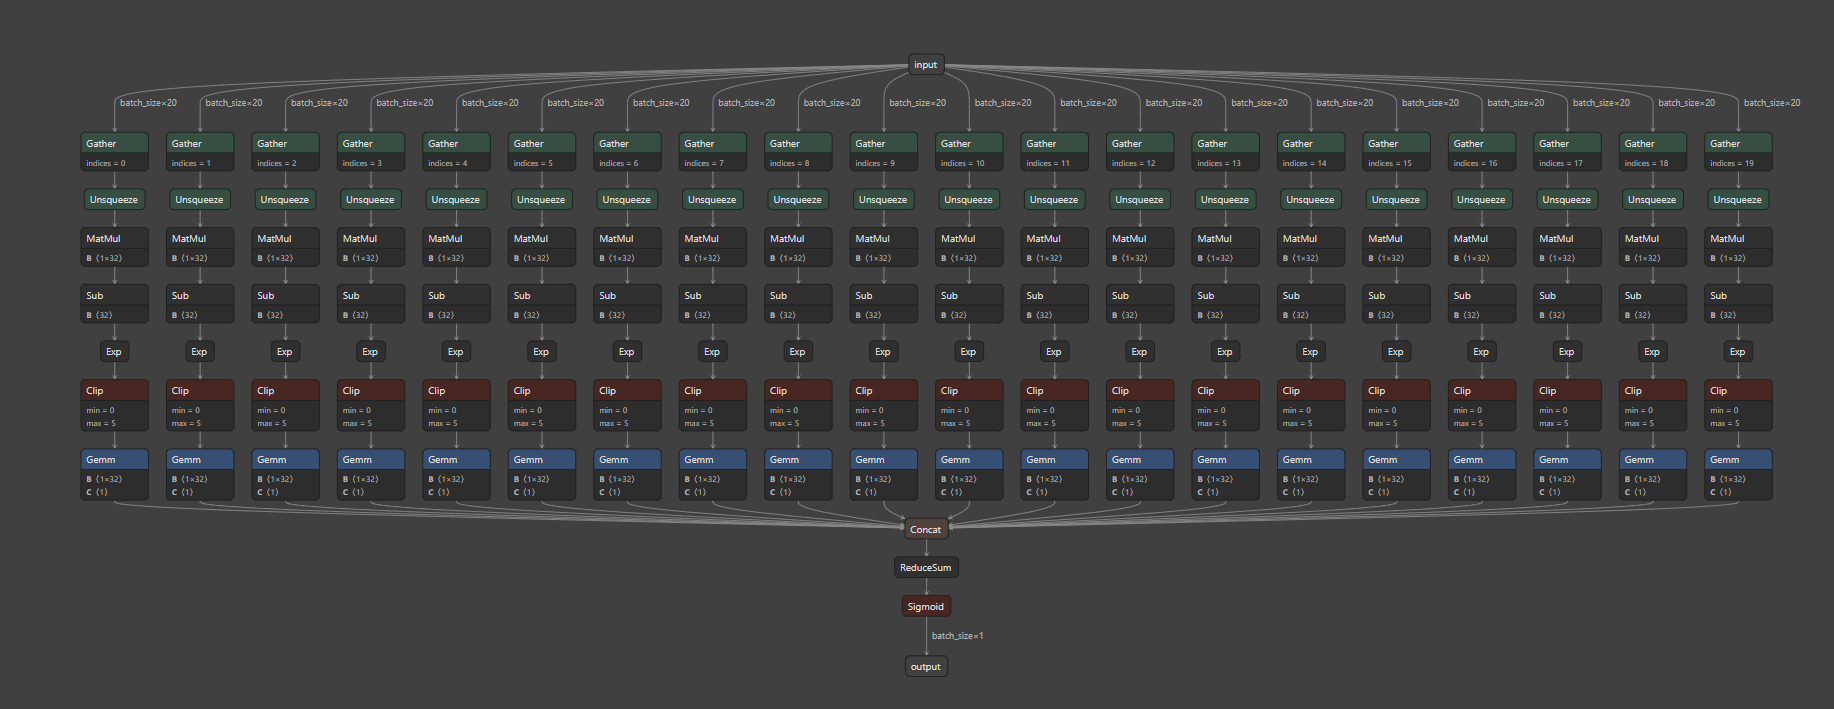

## ✅ What Matches the NAM Paper Design

### 1. Per-Feature Subnetworks
- ✅ The model has **20 parallel branches**, matching the 20 input features.
- Each branch begins with `Gather` → `Unsqueeze`, meaning it isolates **one feature at a time**.
- This mirrors the NAM concept:
  
  $$
  f_i(x_i)
  $$

  where each input feature \( x_i \) is passed through its own subnetwork \( f_i \).

---

### 2. Nonlinear Transformation Using ExU

Each branch includes the following:

- `MatMul + Sub`: A learnable **linear transformation** with bias.
- `Exp`: An **exponential transformation**.
- `Clip`: A **ReLU-n cap** (from 0 to 5).
- `Gemm`: A final **linear layer** producing the per-feature output.

This sequence matches the ExU unit definition:

$$
f_i(x_i) = \text{Linear}\left(\text{ReLU}_n\left(\exp(w(x_i - b))\right)\right)
$$

---

### 3. Final Aggregation: Additive Combination

- All outputs are concatenated using `Concat` → `ReduceSum`.
- The sum is passed through a `Sigmoid`:

  $$
  \hat{y} = \sigma\left(\sum_i f_i(x_i)\right)
  $$

- This follows the **GAM/NAM style** of additive models for binary classification.

---

## 🧠 Summary Table

| Paper Component               | Your ONNX Model |
|------------------------------|-----------------|
| Per-feature subnetworks      | ✅ Present      |
| ExU-style activation layers  | ✅ Present      |
| Additive output aggregation  | ✅ Present      |
| Final sigmoid layer          | ✅ Present      |

---

## ✅ You're Good to Go!

We have a **faithful PyTorch implementation of NAM**, which is:
- Modular
- Interpretable
- Fully differentiable

### Key Capabilities Enabled:
- ✅ Feature-level visualization
- ✅ ExU-based subnetworks
- ✅ ONNX export for visualization (e.g., Netron)

---

### We could try further to:
- 🔄 **multitask outputs** (like in the paper)?
- 🧪 Add **dropout**, **weight decay**, or **penalties** for regularization?
- run hyperparameter search

